 #  A Whale off the Port(folio)
 ---

 In this assignment, you'll get to use what you've learned this week to evaluate the performance among various algorithmic, hedge, and mutual fund portfolios and compare them against the S&P TSX 60 Index.

In [1]:
# Initial imports
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os
import requests
import alpaca_trade_api as tradeapi
from datetime import datetime, timedelta

%matplotlib inline

# Data Cleaning

In this section, you will need to read the CSV files into DataFrames and perform any necessary data cleaning steps. After cleaning, combine all DataFrames into a single DataFrame.

Files:

* `whale_returns.csv`: Contains returns of some famous "whale" investors' portfolios.

* `algo_returns.csv`: Contains returns from the in-house trading algorithms from Harold's company.

* `sp_tsx_history.csv`: Contains historical closing prices of the S&P TSX 60 Index.

## Whale Returns

Read the Whale Portfolio daily returns and clean the data.

In [2]:
# Reading whale returns
whale_portfolio_data_path = Path("Resources/whale_returns.csv")
whale_data = pd.read_csv(whale_portfolio_data_path, index_col="Date", parse_dates=True)
whale_data.head()

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC
Date,,,,
2015-03-02,NaN,NaN,NaN,NaN
2015-03-03,-0.001266,-0.004981,-0.000496,-0.006569
2015-03-04,0.002230,0.003241,-0.002534,0.004213
2015-03-05,0.004016,0.004076,0.002355,0.006726
2015-03-06,-0.007905,-0.003574,-0.008481,-0.013098


In [3]:
# Count nulls
whale_data.isnull().sum()

SOROS FUND MANAGEMENT LLC      1
PAULSON & CO.INC.              1
TIGER GLOBAL MANAGEMENT LLC    1
BERKSHIRE HATHAWAY INC         1
dtype: int64

In [4]:
# Drop nulls
whale_data = whale_data.dropna().copy()
whale_data

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC
Date,,,,
2015-03-03,-0.001266,-0.004981,-0.000496,-0.006569
2015-03-04,0.002230,0.003241,-0.002534,0.004213
2015-03-05,0.004016,0.004076,0.002355,0.006726
2015-03-06,-0.007905,-0.003574,-0.008481,-0.013098
2015-03-09,0.000582,0.004225,0.005843,-0.001652
...,...,...,...,...
2019-04-25,-0.000285,-0.001291,-0.005153,0.004848
2019-04-26,0.008149,0.009162,0.012355,0.010434
2019-04-29,0.001254,0.002719,0.006251,0.005223


## Algorithmic Daily Returns

Read the algorithmic daily returns and clean the data.

In [5]:
# Reading algorithmic returns
algo_returns_data_path = Path("Resources/algo_returns.csv")
algo_returns_data = pd.read_csv(algo_returns_data_path, index_col="Date", parse_dates=True)
algo_returns_data

,Algo 1,Algo 2
Date,,
2014-05-28,0.001745,NaN
2014-05-29,0.003978,NaN
2014-05-30,0.004464,NaN
2014-06-02,0.005692,NaN
2014-06-03,0.005292,NaN
...,...,...
2019-04-25,0.000682,-0.007247
2019-04-26,0.002981,0.005256
2019-04-29,0.005208,0.002829


In [6]:
# Count nulls
algo_returns_data.isnull().sum()

Algo 1    0
Algo 2    6
dtype: int64

In [7]:
# Drop nulls
algo_returns_data = algo_returns_data.dropna().copy()

## S&P TSX 60 Returns

Read the S&P TSX 60 historic closing prices and create a new daily returns DataFrame from the data. 

In [50]:
# Reading S&P TSX 60 Closing Prices
sp_tsx_history_data_path = Path("Resources/sp_tsx_history.csv")
sp_tsx_history_data = pd.read_csv(sp_tsx_history_data_path, index_col="Date", parse_dates=True)
sp_tsx_history_data

,Close
Date,
2012-10-01,"$12,370.19"
2012-10-02,"$12,391.23"
2012-10-03,"$12,359.47"
2012-10-04,"$12,447.68"
2012-10-05,"$12,418.99"
...,...
2019-12-20,"$17,118.44"
2019-12-23,"$17,128.71"
2019-12-24,"$17,180.15"


In [51]:
# Check Data Types
sp_tsx_history_data.index.dtype

dtype('<M8[ns]')

In [52]:
sp_tsx_history_data['Close'].dtype

dtype('O')

In [53]:
# Fix Data Types
whale_data.index = pd.to_datetime(whale_data.index)
algo_returns_data.index = pd.to_datetime(algo_returns_data.index)
sp_tsx_history_data.index = pd.to_datetime(sp_tsx_history_data.index)

In [57]:
def cleanup_money(series):
    series = series.str.replace("$", "", regex=False)
    series = series.str.replace(",", "", regex=False)
    series = series.astype("float")
    return series

In [58]:
sp_tsx_history_data["Close"] = cleanup_money(sp_tsx_history_data["Close"])
sp_tsx_history_data

In [13]:
# Calculate Daily Returns
sp_tsx_history_daily_returns = sp_tsx_history_data.pct_change()

In [14]:
# Drop nulls
sp_tsx_history_daily_returns = sp_tsx_history_daily_returns.dropna()
sp_tsx_history_daily_returns.head()

,Close
Date,
2012-10-02,0.001701
2012-10-03,-0.002563
2012-10-04,0.007137
2012-10-05,-0.002305
2012-10-09,-0.011709


In [15]:
# Rename `Close` Column to be specific to this portfolio.
sp_tsx_history_daily_returns = sp_tsx_history_daily_returns.rename(columns={'Close': 'SP TSX'})

## Combine Whale, Algorithmic, and S&P TSX 60 Returns

In [16]:
joined_data_cols = pd.concat(
    [whale_data, algo_returns_data, sp_tsx_history_daily_returns], axis="columns", join="outer"
).dropna()

joined_data_cols

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC,Algo 1,Algo 2,SP TSX
Date,,,,,,,
2015-03-03,-0.001266,-0.004981,-0.000496,-0.006569,-0.001942,-0.000949,-0.008530
2015-03-04,0.002230,0.003241,-0.002534,0.004213,-0.008589,0.002416,-0.003371
2015-03-05,0.004016,0.004076,0.002355,0.006726,-0.000955,0.004323,0.001344
2015-03-06,-0.007905,-0.003574,-0.008481,-0.013098,-0.004957,-0.011460,-0.009972
2015-03-09,0.000582,0.004225,0.005843,-0.001652,-0.005447,0.001303,-0.006555
...,...,...,...,...,...,...,...
2019-04-25,-0.000285,-0.001291,-0.005153,0.004848,0.000682,-0.007247,-0.000628
2019-04-26,0.008149,0.009162,0.012355,0.010434,0.002981,0.005256,0.002254
2019-04-29,0.001254,0.002719,0.006251,0.005223,0.005208,0.002829,-0.000788


---

# Conduct Quantitative Analysis

In this section, you will calculate and visualize performance and risk metrics for the portfolios.

## Performance Anlysis

#### Calculate and Plot the daily returns.

<AxesSubplot:title={'center':'Daily Returns'}, xlabel='Date'>

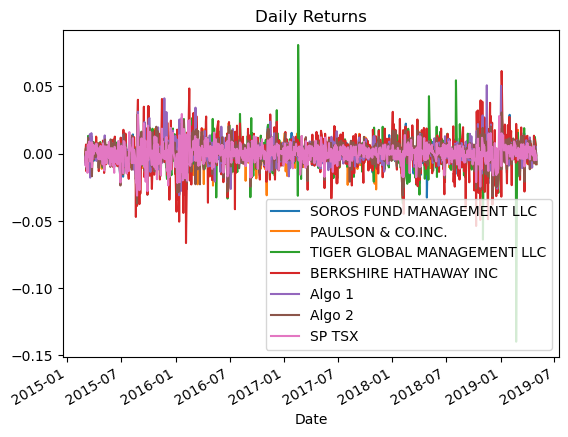

In [17]:
# Plot daily returns of all portfolios
joined_data_cols.plot(title="Daily Returns")

#### Calculate and Plot cumulative returns.

<AxesSubplot:title={'center':'Cumulative Returns'}, xlabel='Date'>

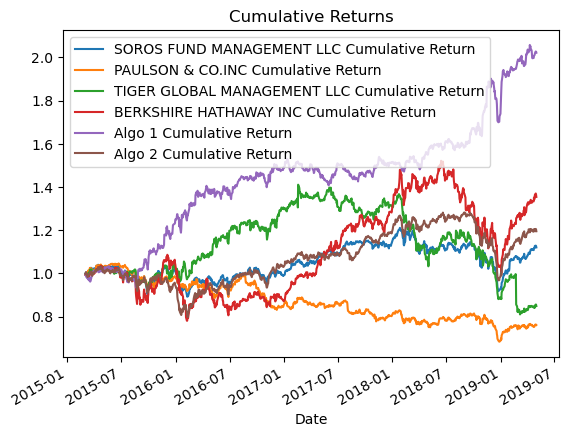

In [18]:
# Calculate cumulative returns of all portfolios
cumulative_returns_df = pd.DataFrame({
    'SOROS FUND MANAGEMENT LLC Cumulative Return': (1 + joined_data_cols['SOROS FUND MANAGEMENT LLC']).cumprod(),
    'PAULSON & CO.INC Cumulative Return': (1 + joined_data_cols['PAULSON & CO.INC. ']).cumprod(),
    'TIGER GLOBAL MANAGEMENT LLC Cumulative Return': (1 + joined_data_cols['TIGER GLOBAL MANAGEMENT LLC']).cumprod(),    
    'BERKSHIRE HATHAWAY INC Cumulative Return': (1 + joined_data_cols['BERKSHIRE HATHAWAY INC']).cumprod(),
    'Algo 1 Cumulative Return': (1 + joined_data_cols['Algo 1']).cumprod(),
    'Algo 2 Cumulative Return': (1 + joined_data_cols['Algo 2']).cumprod(),
    #'SP TSX Cumulative Return': (1 + joined_daily_data_cols['SP TSX']).cumprod(),    
})

# Plot cumulative returns
cumulative_returns_df.plot(title="Cumulative Returns")

---

## Risk Analysis

Determine the _risk_ of each portfolio:

1. Create a box plot for each portfolio. 
2. Calculate the standard deviation for all portfolios.
4. Determine which portfolios are riskier than the S&P TSX 60.
5. Calculate the Annualized Standard Deviation.

### Create a box plot for each portfolio


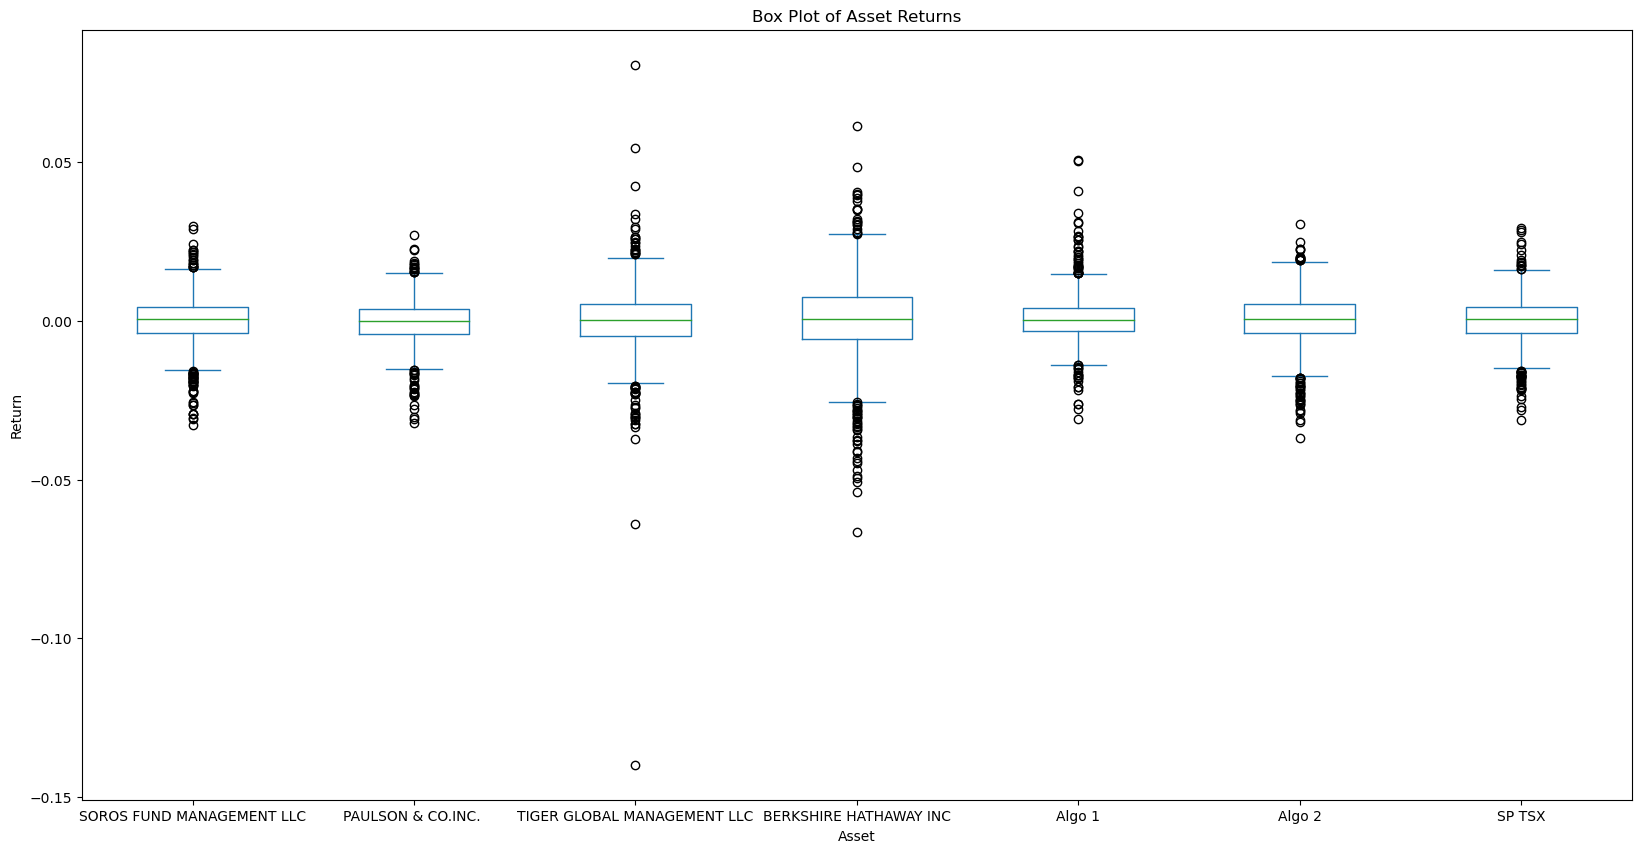

In [19]:
# Box plot to visually show risk
joined_data_cols.plot.box(figsize=(20, 10), title='Box Plot of Asset Returns')
plt.ylabel('Return')
plt.xlabel('Asset')
plt.show()

### Calculate Standard Deviations

In [20]:
# Calculate the daily standard deviations of all portfolios
soros_daily_std = joined_data_cols['SOROS FUND MANAGEMENT LLC'].std()
paulson_daily_std = joined_data_cols['PAULSON & CO.INC. '].std()
tiger_daily_std = joined_data_cols['TIGER GLOBAL MANAGEMENT LLC'].std()
berk_daily_std = joined_data_cols['BERKSHIRE HATHAWAY INC'].std()
algo1_daily_std = joined_data_cols['Algo 1'].std()
algo2_daily_std = joined_data_cols['Algo 2'].std()

### Determine which portfolios are riskier than the S&P TSX 60

In [21]:
# Calculate the daily standard deviation of S&P TSX 60
sptsx_daily_std = joined_data_cols['SP TSX'].std()
# Determine which portfolios are riskier than the S&P TSX 60
joined_standard_deviation = joined_data_cols.std()
joined_standard_deviation = joined_standard_deviation.sort_values(ascending=False)
joined_standard_deviation

BERKSHIRE HATHAWAY INC         0.012826
TIGER GLOBAL MANAGEMENT LLC    0.010883
Algo 2                         0.008326
SOROS FUND MANAGEMENT LLC      0.007828
Algo 1                         0.007589
SP TSX                         0.007034
PAULSON & CO.INC.              0.006982
dtype: float64

All have a large risk except for Paulson & Co. Inc.

### Calculate the Annualized Standard Deviation

In [22]:
# Calculate the annualized standard deviation (252 trading days)
annualized_std = joined_standard_deviation * np.sqrt(252)
annualized_std

BERKSHIRE HATHAWAY INC         0.203599
TIGER GLOBAL MANAGEMENT LLC    0.172759
Algo 2                         0.132177
SOROS FUND MANAGEMENT LLC      0.124259
Algo 1                         0.120470
SP TSX                         0.111664
PAULSON & CO.INC.              0.110841
dtype: float64

---

## Rolling Statistics

Risk changes over time. Analyze the rolling statistics for Risk and Beta. 

1. Calculate and plot the rolling standard deviation for for all portfolios using a 21-day window.
2. Calculate the correlation between each stock to determine which portfolios may mimick the S&P TSX 60.
3. Choose one portfolio, then calculate and plot the 60-day rolling beta for it and the S&P TSX 60.

### Calculate and plot rolling `std` for all portfolios with 21-day window

<AxesSubplot:xlabel='Date'>

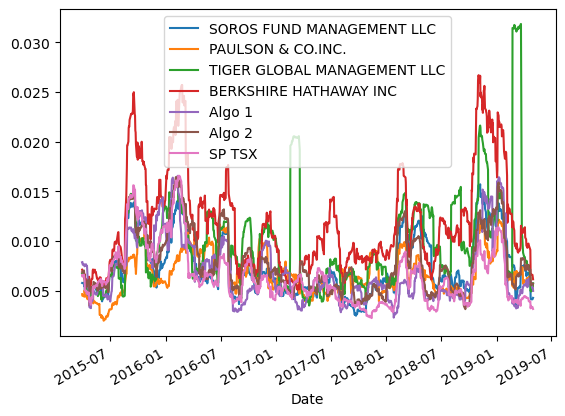

In [23]:
# Calculate the rolling standard deviation for all portfolios using a 21-day window
rolling = joined_data_cols.rolling(window=21).std()
# Plot the rolling standard deviation
rolling.plot()

### Calculate and plot the correlation

In [24]:
# Calculate the correlation
correlation = joined_data_cols.corr()
# Display de correlation matrix
correlation

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC,Algo 1,Algo 2,SP TSX
SOROS FUND MANAGEMENT LLC,1.000000,0.697076,0.560964,0.750181,0.313795,0.826667,0.673930
PAULSON & CO.INC.,0.697076,1.000000,0.433034,0.540033,0.266363,0.674015,0.486511
TIGER GLOBAL MANAGEMENT LLC,0.560964,0.433034,1.000000,0.423524,0.161236,0.506689,0.440583
BERKSHIRE HATHAWAY INC,0.750181,0.540033,0.423524,1.000000,0.289378,0.684609,0.557250
Algo 1,0.313795,0.266363,0.161236,0.289378,1.000000,0.285455,0.310276
Algo 2,0.826667,0.674015,0.506689,0.684609,0.285455,1.000000,0.737370
SP TSX,0.673930,0.486511,0.440583,0.557250,0.310276,0.737370,1.000000


<AxesSubplot:>

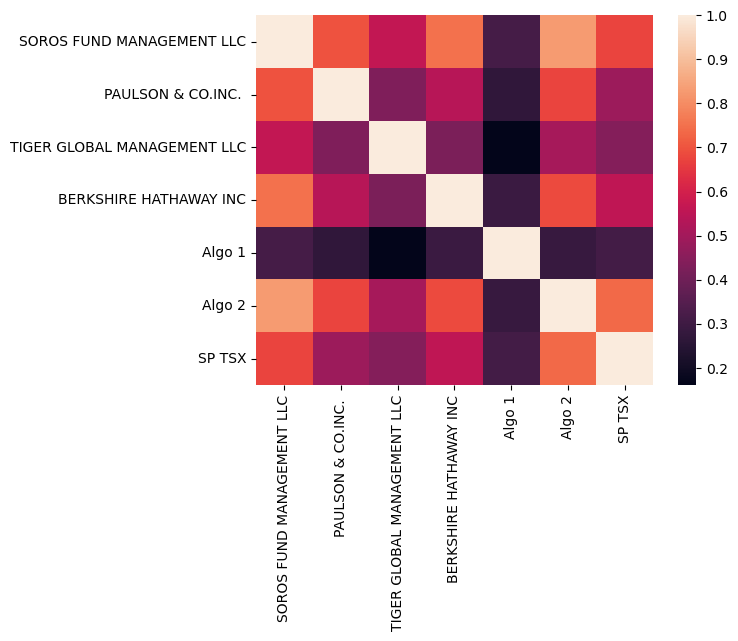

In [25]:
vmin = np.nanmin(correlation)
vmax = np.nanmax(correlation)
sns.heatmap(correlation, vmin=vmin, vmax=vmax)

### Calculate and Plot Beta for a chosen portfolio and the S&P 60 TSX

In [92]:
def beta(x,y):
    # Calculate covariance of a single portfolio
    covariance = x.cov(y)
    # Calculate variance of S&P TSX
    variance = y.var()
    # Computing beta
    beta = covariance / variance
    return beta

In [94]:
beta1 = beta(joined_data_cols['SOROS FUND MANAGEMENT LLC'], joined_data_cols['SP TSX'])
beta1

1.0140823174416056

In [95]:
def rolling_beta(x,y,days):
    rolling_covariance = x.rolling(window=days).cov(y)
    rolling_variance = y.rolling(window=days).var()
    rolling_beta = rolling_covariance / rolling_variance
    return rolling_beta

<AxesSubplot:title={'center':'Rolling 60-Day Beta of Soros Fund Management'}, xlabel='Date'>

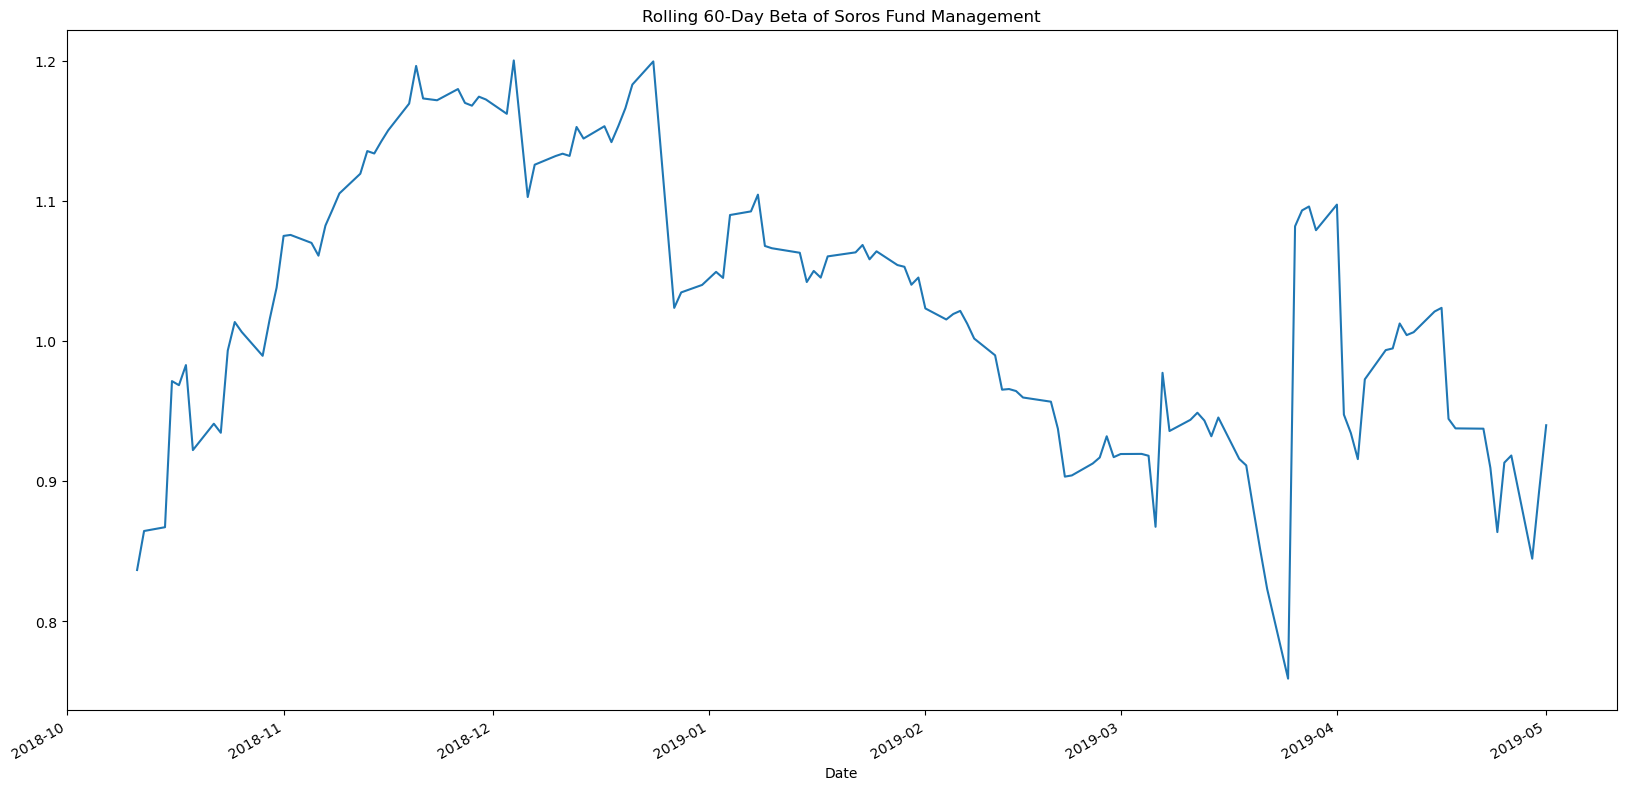

In [96]:
# Plot beta trend
rolling_beta1 = rolling_beta(joined_data_cols['SOROS FUND MANAGEMENT LLC'], joined_data_cols['SP TSX'], 60)
rolling_beta1.plot(figsize=(20, 10), title='Rolling 60-Day Beta of Soros Fund Management')

In [ ]:
# Calculate covariance of a single portfolio
#covariance = joined_data_cols['SOROS FUND MANAGEMENT LLC'].cov(joined_data_cols['SP TSX'])
# Calculate variance of S&P TSX
#variance = joined_data_cols['SP TSX'].var()
# Computing beta
#soros_beta = covariance / variance
# Plot beta trend
#rolling_covariance = joined_data_cols['SOROS FUND MANAGEMENT LLC'].rolling(window=30).cov(joined_data_cols['SP TSX'])
#rolling_variance = joined_data_cols['SP TSX'].rolling(window=30).var()
#rolling_beta = rolling_covariance / rolling_variance

## Rolling Statistics Challenge: Exponentially Weighted Average 

An alternative way to calculate a rolling window is to take the exponentially weighted moving average. This is like a moving window average, but it assigns greater importance to more recent observations. Try calculating the [`ewm`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html) with a 21-day half life for each portfolio, using standard deviation (`std`) as the metric of interest.

In [27]:
# Use `ewm` to calculate the rolling window
exponentially_weighted_average = joined_data_cols.ewm(halflife=21).std()
exponentially_weighted_average

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC,Algo 1,Algo 2,SP TSX
Date,,,,,,,
2015-03-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-04,0.002472,0.005814,0.001441,0.007624,0.004700,0.002380,0.003648
2015-03-05,0.002677,0.004968,0.002478,0.007020,0.004162,0.002662,0.004936
2015-03-06,0.005349,0.004615,0.004665,0.009387,0.003419,0.007166,0.005205
2015-03-09,0.004638,0.004471,0.005496,0.008066,0.002999,0.006290,0.004517
...,...,...,...,...,...,...,...
2019-04-25,0.006819,0.006342,0.014811,0.010830,0.006526,0.007500,0.004700
2019-04-26,0.006819,0.006448,0.014764,0.010763,0.006433,0.007418,0.004628
2019-04-29,0.006708,0.006357,0.014575,0.010601,0.006378,0.007304,0.004564


<AxesSubplot:xlabel='Date'>

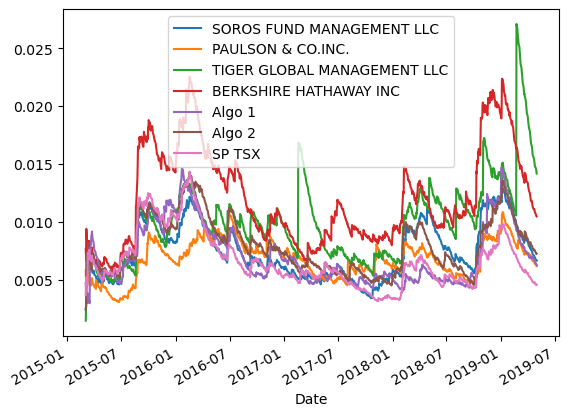

In [28]:
exponentially_weighted_average.plot()

# Sharpe Ratios
In reality, investment managers and thier institutional investors look at the ratio of return-to-risk, and not just returns alone. After all, if you could invest in one of two portfolios, and each offered the same 10% return, yet one offered lower risk, you'd take that one, right?

### Using the daily returns, calculate and visualize the Sharpe ratios using a bar plot

In [72]:
joined_data_cols

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC,Algo 1,Algo 2,SP TSX,Portfolio
Date,,,,,,,,
2018-07-17,0.000130,-0.002424,0.004608,0.001477,-0.002263,0.001961,0.001486,0.019444
2018-07-18,-0.000118,-0.001467,-0.012127,-0.003227,-0.000998,0.001798,-0.002533,0.000156
2018-07-19,-0.004176,-0.004656,-0.004325,-0.007676,0.001159,0.002503,0.003982,-0.006840
2018-07-20,-0.001612,-0.001695,-0.005898,-0.003937,-0.004348,-0.001046,-0.006501,-0.017088
2018-07-23,-0.002118,-0.001390,-0.002287,0.001667,-0.001495,0.002133,-0.000890,-0.013075
...,...,...,...,...,...,...,...,...
2019-04-25,-0.000285,-0.001291,-0.005153,0.004848,0.000682,-0.007247,-0.000628,-0.019052
2019-04-26,0.008149,0.009162,0.012355,0.010434,0.002981,0.005256,0.002254,0.021524
2019-04-29,0.001254,0.002719,0.006251,0.005223,0.005208,0.002829,-0.000788,0.006449


In [83]:
def sharpe_ratio(expected_return, risk_free_return, standard_deviation):
    value = ((expected_return) * 252) / (standard_deviation * np.sqrt(252))
    return value

In [84]:
sharpe_ratios1 = sharpe_ratio(joined_data_cols.mean(), 0, joined_data_cols.std())
sharpe_ratios1

SOROS FUND MANAGEMENT LLC     -0.065666
PAULSON & CO.INC.             -0.298776
TIGER GLOBAL MANAGEMENT LLC   -1.583048
BERKSHIRE HATHAWAY INC        -0.284501
Algo 1                         2.139963
Algo 2                        -0.380828
SP TSX                        -0.079285
Portfolio                     -0.422499
dtype: float64

In [85]:
# Annualized Sharpe Ratios
#sharpe_ratio1 = (joined_data_cols.mean() * 252) / (joined_data_cols.std() * np.sqrt(252))
#sharpe_ratio1

<AxesSubplot:title={'center':'Sharpe Ratios'}>

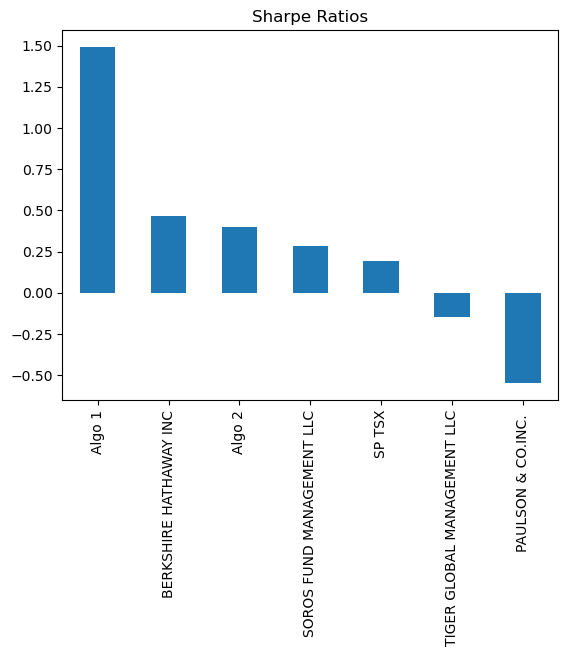

In [30]:
# Visualize the sharpe ratios as a bar plot
sharpe_ratios.sort_values(ascending=False).plot(kind="bar", title="Sharpe Ratios")

### Determine whether the algorithmic strategies outperform both the market (S&P TSX 60) and the whales portfolios.

Algorithm 1 does better than the whale portfolios and the S&P TSX 60.  Algorithm 2 does better than 3 of of four whales portfolios, slightly under-performing Berkshire Hathaway, and also the S&P TSX 60.

---

# Create Custom Portfolio

In this section, you will build your own portfolio of stocks, calculate the returns, and compare the results to the Whale Portfolios and the S&P TSX 60. 

1. Choose 3-5 custom stocks with at last 1 year's worth of historic prices and create a DataFrame of the closing prices and dates for each stock.
2. Calculate the weighted returns for the portfolio assuming an equal number of shares for each stock.
3. Join your portfolio returns to the DataFrame that contains all of the portfolio returns.
4. Re-run the performance and risk analysis with your portfolio to see how it compares to the others.
5. Include correlation analysis to determine which stocks (if any) are correlated.

## Choose 3-5 custom stocks with at last 1 year's worth of historic prices and create a DataFrame of the closing prices and dates for each stock.

In [31]:
load_dotenv()

True

In [32]:
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
alpaca = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')
today = pd.Timestamp("2023-03-18", tz="America/New_York").isoformat()
symbols = ["F", "HMC", "TSLA"]
timeframe = "1Day"
today = pd.Timestamp("2019-07-14", tz="America/New_York").isoformat()  #Needs to be in the past to match other portfolio data
begin = pd.Timestamp("2018-07-14", tz="America/New_York").isoformat()
stock_data = alpaca.get_bars(symbols, timeframe, start=begin, end=today).df
#stock_data

In [33]:
# Reading data from 1st stock
F = stock_data[stock_data['symbol']=='F'].drop('symbol', axis=1)

In [34]:
# Reading data from 2nd stock
HMC = stock_data[stock_data['symbol']=='HMC'].drop('symbol', axis=1)

In [35]:
# Reading data from 3rd stock
TSLA = stock_data[stock_data['symbol']=='TSLA'].drop('symbol', axis=1)

In [36]:
# Combine all stocks in a single DataFrame
df_portfolio_year = pd.concat([F, HMC, TSLA],axis=1, keys=['F','HMC', 'TSLA'])
df_portfolio_year.head()

F                                              \
                            open    high    low  close    volume trade_count   
timestamp                                                                      
2018-07-16 04:00:00+00:00  10.95  10.970  10.76  10.85  46163437       70717   
2018-07-17 04:00:00+00:00  10.80  10.900  10.80  10.86  37584265       65858   
2018-07-18 04:00:00+00:00  10.85  10.895  10.81  10.87  36420018       65404   
2018-07-19 04:00:00+00:00  10.89  10.900  10.77  10.82  40309117       61608   
2018-07-20 04:00:00+00:00  10.68  10.720  10.51  10.56  41673254       69837   

                                        HMC                   ...          \
                                vwap   open     high     low  ...  volume   
timestamp                                                     ...           
2018-07-16 04:00:00+00:00  10.834022  29.27  29.3899  29.070  ...  594800   
2018-07-17 04:00:00+00:00  10.859315  29.48  29.6950  29.370  ...  784577   
2018-07-18 04:00:00+00:00  10.856594  29.58  29.6100  29.465  ...  472866   
2018-07-19 04:00:00+00:00  10.818350  29.42  29.4900  29.270  ...  545538   
2018-07-20 04:00:00+00:00  10.563717  29.26  29.2850  29.150  ...  355666   

                                                    TSLA                    \
                          trade_count       vwap    open    high       low   
timestamp                                                                    
2018-07-16 04:00:00+00:00        4535  29.156219  311.71  315.16  306.2500   
2018-07-17 04:00:00+00:00        4857  29.566046  308.81  324.74  308.5000   
2018-07-18 04:00:00+00:00        3656  29.525516  325.00  325.50  316.2500   
2018-07-19 04:00:00+00:00        4070  29.364162  316.33  323.54  314.0100   
2018-07-20 04:00:00+00:00        2615  29.214032  321.23  323.24  311.7093   

                                                                    
                            close   volume trade_count        vwap  
timestamp                                                           
2018-07-16 04:00:00+00:00  310.10  7818655       83832  309.117212  
2018-07-17 04:00:00+00:00  322.69  6996232       88194  317.889783  
2018-07-18 04:00:00+00:00  323.85  5624211       58360  321.980033  
2018-07-19 04:00:00+00:00  320.23  5923891       61502  318.271608  
2018-07-20 04:00:00+00:00  313.58  5166547       57243  315.997763  

[5 rows x 21 columns]

In [37]:
# Reset Date index
df_portfolio_year.index = df_portfolio_year.index.date

In [38]:
# Reorganize portfolio data by having a column per symbol
df_closing_prices = pd.DataFrame()
df_closing_prices["F"] = df_portfolio_year["F"]["close"]
df_closing_prices["HMC"] = df_portfolio_year["HMC"]["close"]
df_closing_prices["TSLA"] = df_portfolio_year["TSLA"]["close"]
df_closing_prices.head()

,F,HMC,TSLA
2018-07-16,10.85,29.15,310.10
2018-07-17,10.86,29.64,322.69
2018-07-18,10.87,29.52,323.85
2018-07-19,10.82,29.38,320.23
2018-07-20,10.56,29.19,313.58


In [39]:
# Calculate daily returns
daily_returns = df_closing_prices.pct_change()
# Drop NAs
daily_returns = daily_returns.dropna()
# Display sample data
daily_returns.head()

,F,HMC,TSLA
2018-07-17,0.000922,0.016810,0.040600
2018-07-18,0.000921,-0.004049,0.003595
2018-07-19,-0.004600,-0.004743,-0.011178
2018-07-20,-0.024030,-0.006467,-0.020766
2018-07-23,-0.008523,0.002398,-0.033102


## Calculate the weighted returns for the portfolio assuming an equal number of shares for each stock

In [40]:
# Set weights
weights = [1/3, 1/3, 1/3]

# Calculate portfolio return
portfolio_returns = daily_returns.dot(weights)

# Display sample data
portfolio_returns.head()

2018-07-17    0.019444
2018-07-18    0.000156
2018-07-19   -0.006840
2018-07-20   -0.017088
2018-07-23   -0.013075
dtype: float64

## Join your portfolio returns to the DataFrame that contains all of the portfolio returns

In [41]:
# Join your returns DataFrame to the original returns DataFrame
#daily_returns["Portfolio"] = portfolio_returns
joined_data_cols["Portfolio"] = portfolio_returns

In [42]:
# Only compare dates where return data exists for all the stocks (drop NaNs)
joined_data_cols = joined_data_cols.dropna().copy()
joined_data_cols.head()

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC,Algo 1,Algo 2,SP TSX,Portfolio
Date,,,,,,,,
2018-07-17,0.000130,-0.002424,0.004608,0.001477,-0.002263,0.001961,0.001486,0.019444
2018-07-18,-0.000118,-0.001467,-0.012127,-0.003227,-0.000998,0.001798,-0.002533,0.000156
2018-07-19,-0.004176,-0.004656,-0.004325,-0.007676,0.001159,0.002503,0.003982,-0.006840
2018-07-20,-0.001612,-0.001695,-0.005898,-0.003937,-0.004348,-0.001046,-0.006501,-0.017088
2018-07-23,-0.002118,-0.001390,-0.002287,0.001667,-0.001495,0.002133,-0.000890,-0.013075


## Re-run the risk analysis with your portfolio to see how it compares to the others

### Calculate the Annualized Standard Deviation

In [43]:
# Calculate the annualized `std`
joined_standard_deviation = joined_data_cols.std().sort_values(ascending=False)
annualized_std = joined_standard_deviation * np.sqrt(252)
annualized_std

Portfolio                      0.277799
BERKSHIRE HATHAWAY INC         0.252689
TIGER GLOBAL MANAGEMENT LLC    0.244367
SOROS FUND MANAGEMENT LLC      0.148011
Algo 2                         0.142968
Algo 1                         0.140824
PAULSON & CO.INC.              0.118937
SP TSX                         0.102865
dtype: float64

### Calculate and plot rolling `std` with 21-day window

<AxesSubplot:xlabel='Date'>

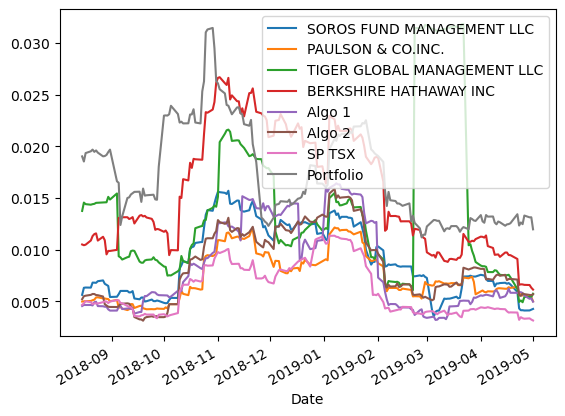

In [44]:
# Calculate rolling standard deviation
rolling = joined_data_cols.rolling(window=21).std()
# Plot rolling standard deviation
rolling.plot()

### Calculate and plot the correlation

In [45]:
# Calculate and plot the correlation
correlation = joined_data_cols.corr()
correlation

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC,Algo 1,Algo 2,SP TSX,Portfolio
SOROS FUND MANAGEMENT LLC,1.000000,0.778675,0.464050,0.804662,0.349157,0.861885,0.704769,0.466069
PAULSON & CO.INC.,0.778675,1.000000,0.475791,0.637631,0.382231,0.780831,0.582627,0.415289
TIGER GLOBAL MANAGEMENT LLC,0.464050,0.475791,1.000000,0.307220,0.127437,0.387656,0.392867,0.254736
BERKSHIRE HATHAWAY INC,0.804662,0.637631,0.307220,1.000000,0.343398,0.767965,0.655623,0.526350
Algo 1,0.349157,0.382231,0.127437,0.343398,1.000000,0.401843,0.326172,0.160825
Algo 2,0.861885,0.780831,0.387656,0.767965,0.401843,1.000000,0.750965,0.459194
SP TSX,0.704769,0.582627,0.392867,0.655623,0.326172,0.750965,1.000000,0.369403
Portfolio,0.466069,0.415289,0.254736,0.526350,0.160825,0.459194,0.369403,1.000000


<AxesSubplot:>

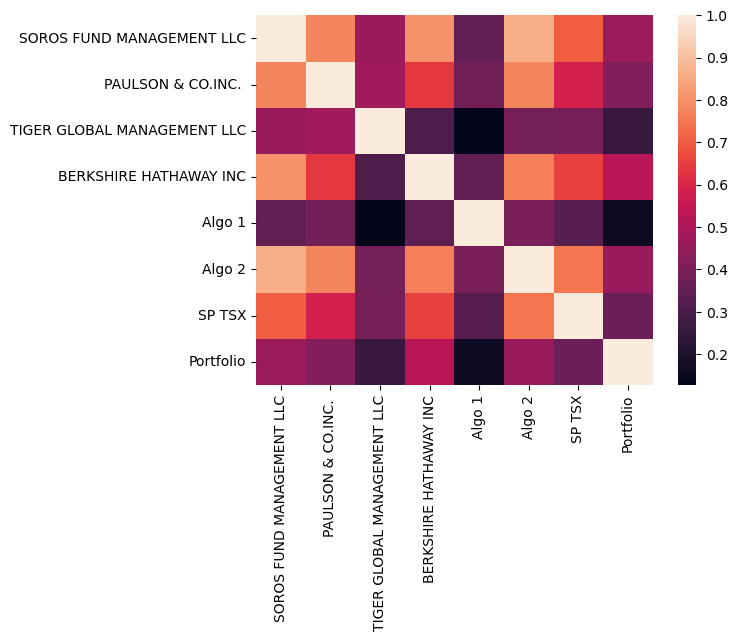

In [46]:
vmin = np.nanmin(correlation)
vmax = np.nanmax(correlation)
sns.heatmap(correlation, vmin=vmin, vmax=vmax)

### Calculate and Plot the 60-day Rolling Beta for Your Portfolio compared to the S&P 60 TSX

<AxesSubplot:title={'center':'Rolling 60-Day Beta of Portfolio'}, xlabel='Date'>

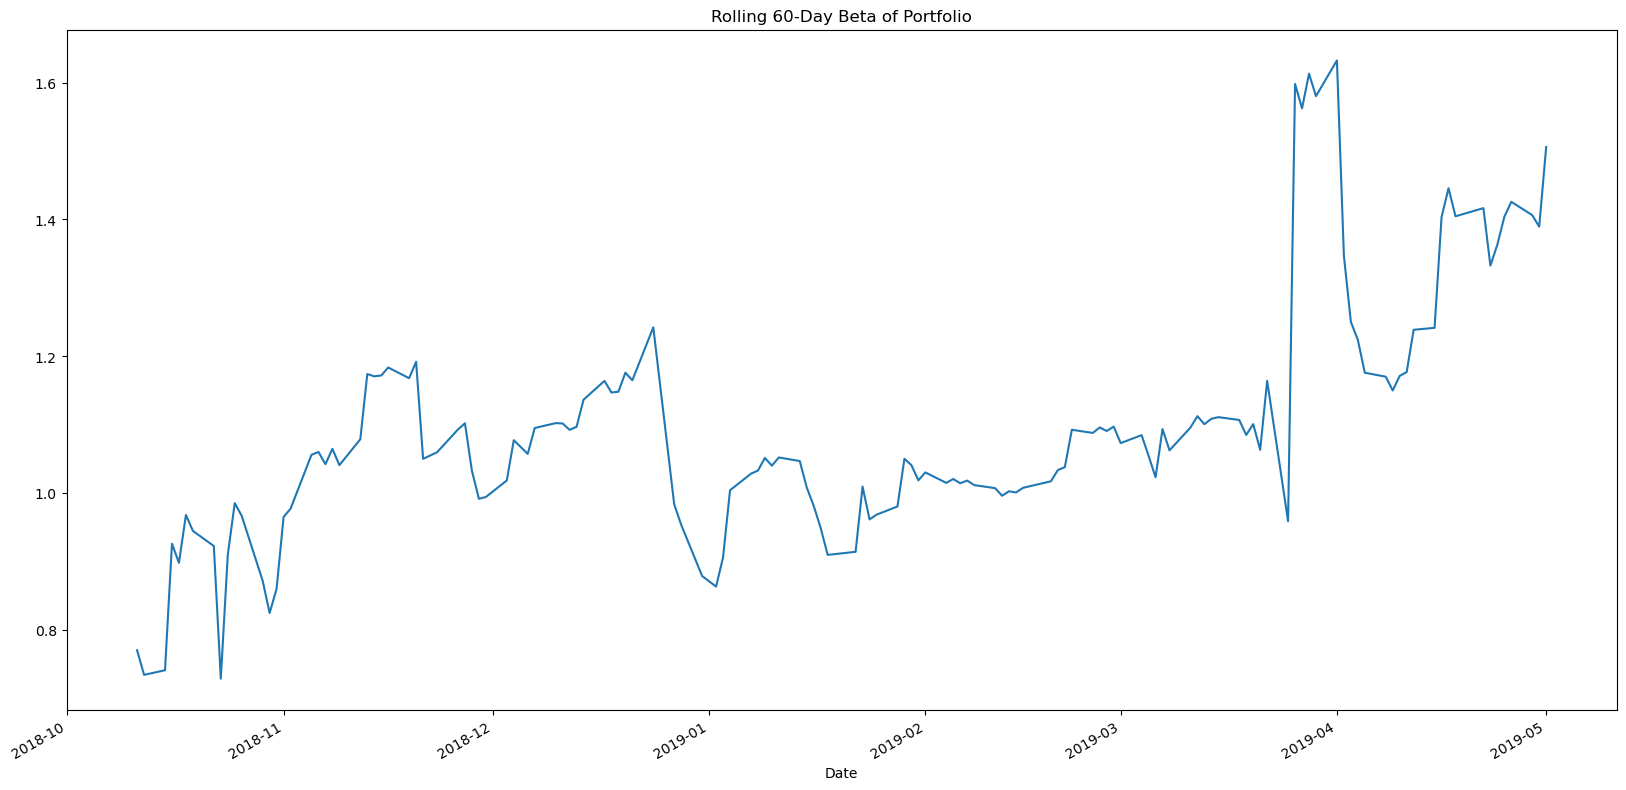

In [97]:
# Calculate and plot Beta
#covariance = joined_data_cols["Portfolio"].cov(joined_data_cols['SP TSX'])
#variance = joined_data_cols['SP TSX'].var()
#soros_beta = covariance / variance
#rolling_covariance = joined_data_cols['Portfolio'].rolling(window=60).cov(joined_data_cols['SP TSX'])
#rolling_variance = joined_data_cols['SP TSX'].rolling(window=60).var()
#rolling_beta = rolling_covariance / rolling_variance
#rolling_beta.plot(figsize=(20, 10), title='Rolling 60-Day Beta of Portfolio')

rolling_beta2 = rolling_beta(joined_data_cols["Portfolio"], joined_data_cols['SP TSX'], 60)
rolling_beta2.plot(figsize=(20, 10), title='Rolling 60-Day Beta of Portfolio')

### Using the daily returns, calculate and visualize the Sharpe ratios using a bar plot

In [87]:
sharpe_ratio2 = sharpe_ratio(joined_data_cols.mean(), 0, joined_data_cols.std())
sharpe_ratio2.sort_values(ascending=False)

Algo 1                         2.139963
SOROS FUND MANAGEMENT LLC     -0.065666
SP TSX                        -0.079285
BERKSHIRE HATHAWAY INC        -0.284501
PAULSON & CO.INC.             -0.298776
Algo 2                        -0.380828
Portfolio                     -0.422499
TIGER GLOBAL MANAGEMENT LLC   -1.583048
dtype: float64

In [88]:
# Calculate Annualized Sharpe Ratios
#sharpe_ratios = (joined_data_cols.mean() * 252) / (joined_data_cols.std() * np.sqrt(252))
#sharpe_ratios.sort_values(ascending=False)

<AxesSubplot:title={'center':'Sharpe Ratios'}>

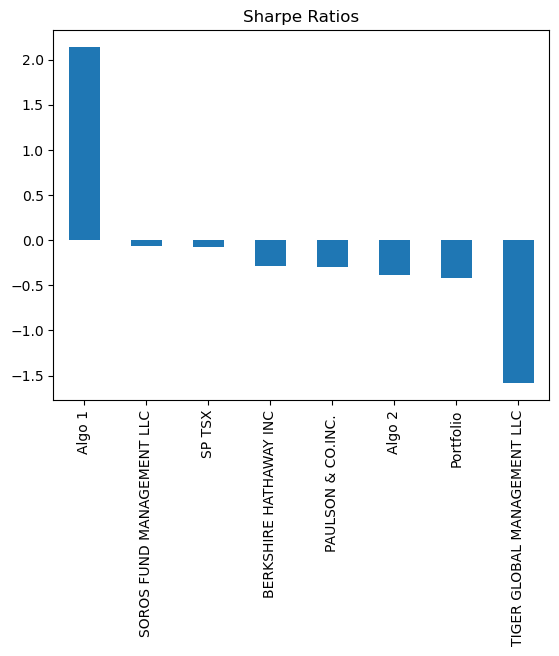

In [49]:
# Visualize the sharpe ratios as a bar plot
sharpe_ratios.sort_values(ascending=False).plot(kind="bar", title="Sharpe Ratios")

### How does your portfolio do?

Poorly!  Worse than all of the other portfolios except for Tiger Global Management LLC.